# Questão 6 Prova de TV Digital
* Aluno: Yuri Sales Ribeiro - 375177

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.fftpack
import cv2

In [279]:
# Funções para realizar DCT e DCT inversa bi-dimensional
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def empirical_cdf(data):
    # Calculates the empirical cdf of the given data returning the ordered data 
    # values (x) and the cumulative sum of the probabilities (y).
    x, y = np.unique(data, return_counts=True)
    return x, np.cumsum(y)/data.size

# Função para realizar a DCT em blocos de tamanha [8,16,64]
def DCT_blocks(img):
    h,w = np.array(img.shape)
    Block_size = [8,16,64]
    dct_img = np.zeros([h,w,3])
    for b in range(len(Block_size)):
        dct_img[:,:,b] = np.zeros([h,w])
        for i in np.r_[:h:Block_size[b]]:
            for j in np.r_[:w:Block_size[b]]:
                dct_img[:,:,b][i : (i + Block_size[b]), j : (j + Block_size[b])] = dct2(img[i : (i + Block_size[b]), j : (j + Block_size[b])])
    return dct_img

# Função para realizar a DCT inversa em blocos a serem informados
def IDCT_blocks(img,Block_size):
    h,w = np.array(img.shape)
#     Block_size = [8,16,64]
#     b = 0
    idct_img = np.zeros([h,w])
#     for b in range(len(Block_size)):
    for i in np.r_[:h:Block_size]:
        for j in np.r_[:w:Block_size]:
            idct_img[i : (i + Block_size), j : (j + Block_size)] = idct2(img[i : (i + Block_size), j : (j + Block_size)])
    return idct_img

# Função para realizar o truncamento dos coeficientes a partir de um threshold
def Truncated_coef(img,Threshold):
    h,w = np.array(img.shape)
    img_thresh = np.zeros([h,w])
    a = img.reshape(h*w)
    x,y = empirical_cdf(np.abs(a[np.where(a != 0)[0]]))
    th = np.where(y>=(1-Threshold/100))[0][0]
    img_thresh = img * (abs(img) > x[th])
    return img_thresh        

# Função para realizar a estimação da PSNR
def PSNR(orig,est):
    h,w = np.array(orig.shape)
    mse = np.mean((est - orig)**2)
    if mse == 0:
        mse = 1
    psnr = 2*10*np.log10(255/mse)
    return psnr

A função utilizada para fazer o truncamento dos coeficientes se baseia na energia deles. Ou seja, os coeficientes escolhidos são os $x$ % com maior energia.

O truncamento é feito utilizando uma cdf, excluindo os coeficientes nulos, para estimar o threshold que contém essa porcentagem dos coeficientes.

In [249]:
# Lendo as imagens
# A função cv2.imread já lê a imagem em GBR, repetindo o grayscale nas três componentes 
caves = cv2.imread('caves.jpg')
clouds = cv2.imread('clouds.jpg')

# Transformando de RGB para YCrCb.
cavesycc = cv2.cvtColor(caves,cv2.COLOR_RGB2YCrCb)
cloudsycc = cv2.cvtColor(clouds,cv2.COLOR_RGB2YCrCb)

# Isolando as componentes Y
cavesy = cavesycc[:,:,0]
cloudsy = cloudsycc[:,:,0]

# Dimensões das imagens
h,w = np.array(cloudsy.shape)

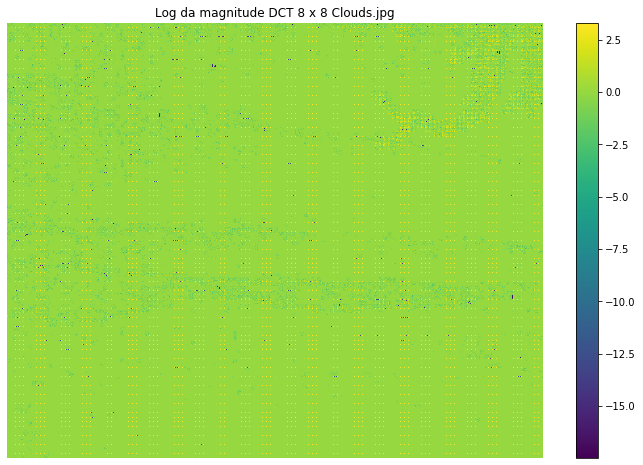

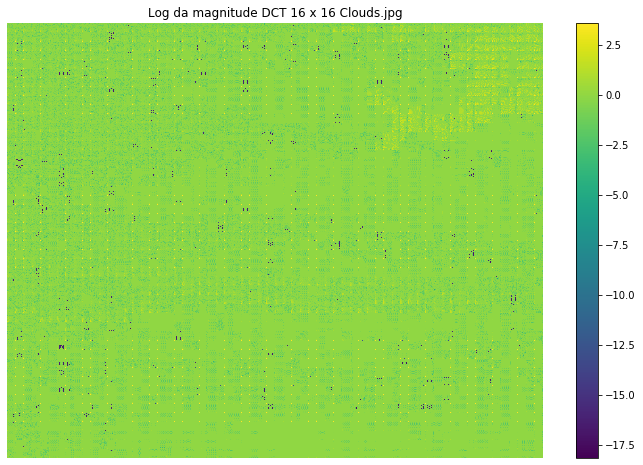

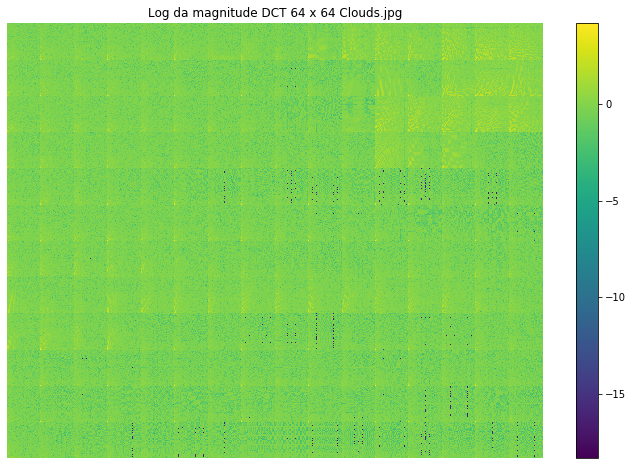

In [213]:
# Plot do log das magnitudes para a figura Clouds.jpg
dct_clouds = DCT_blocks(cloudsy)
for b in range (len(Block_size)):
    plt.figure(b,figsize=(12,8))
    log_dct = np.ma.log10(dct_clouds[:,:,b])
    log_dct = log_dct.filled(0)
    
    plt.pcolormesh(log_dct)
    plt.title('Log da magnitude DCT ' + str(Block_size[b])+' x '+ (str(Block_size[b]))+ ' Clouds.jpg')
    plt.colorbar()
    plt.axis('off')


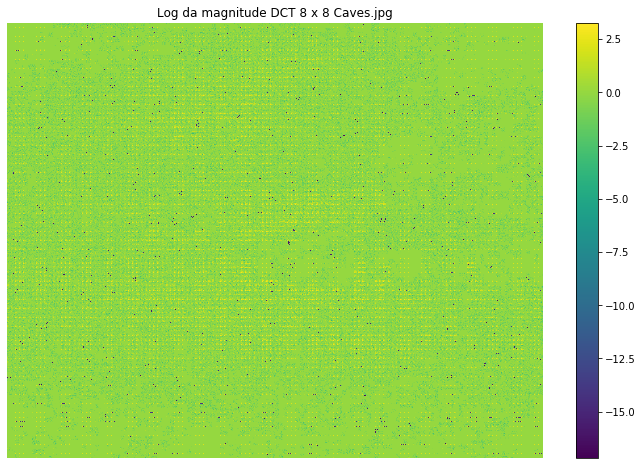

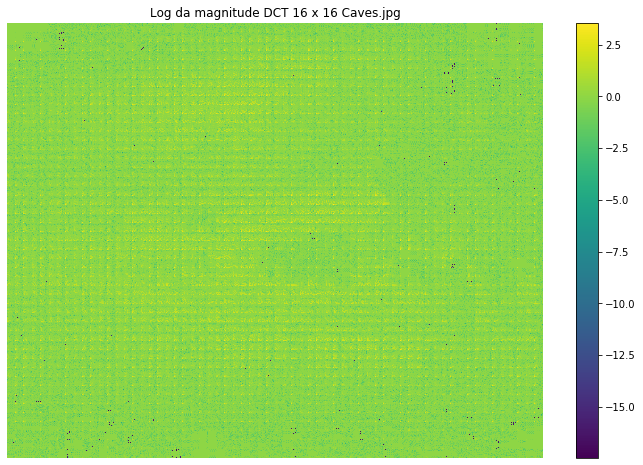

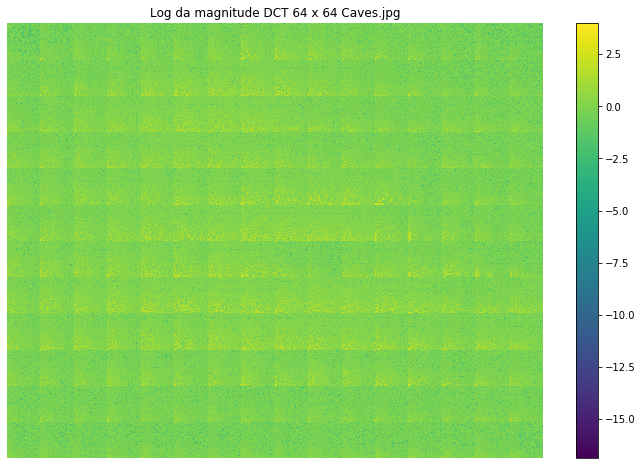

In [214]:
# Plot do log das magnitudes para a figura caves.jpg
dct_caves = DCT_blocks(cavesy)
for b in range (len(Block_size)):
    plt.figure(b,figsize=(12,8))
    log_dct = np.ma.log10(dct_caves[:,:,b])
    log_dct = log_dct.filled(0)
    
    plt.pcolormesh(log_dct)
    plt.title('Log da magnitude DCT ' + str(Block_size[b])+' x '+ (str(Block_size[b]))+ ' Caves.jpg')
    plt.colorbar()
    plt.axis('off')


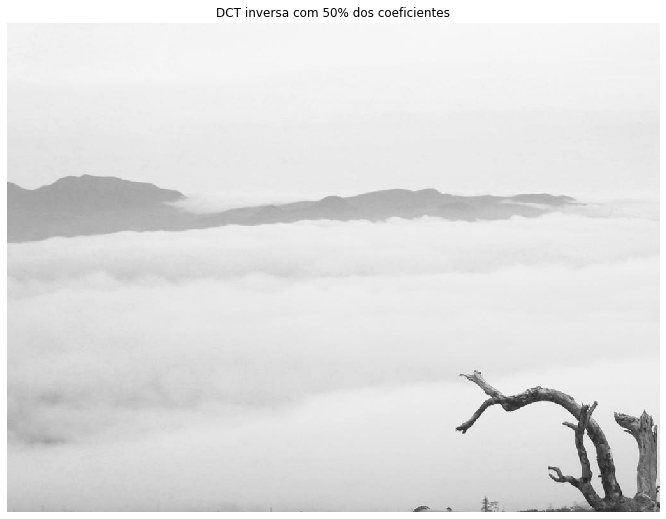

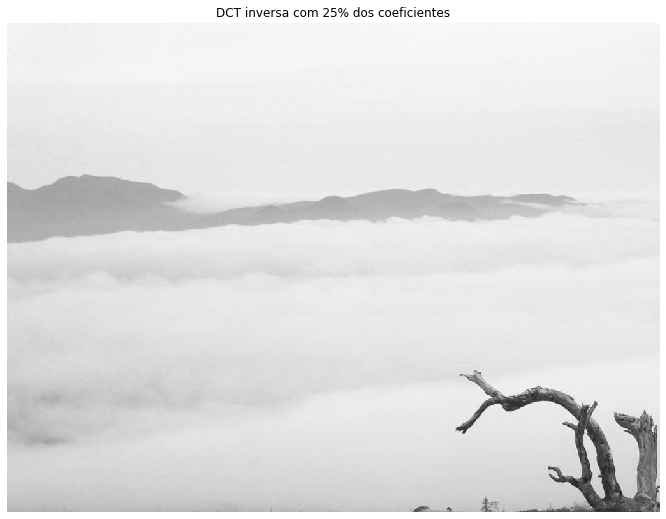

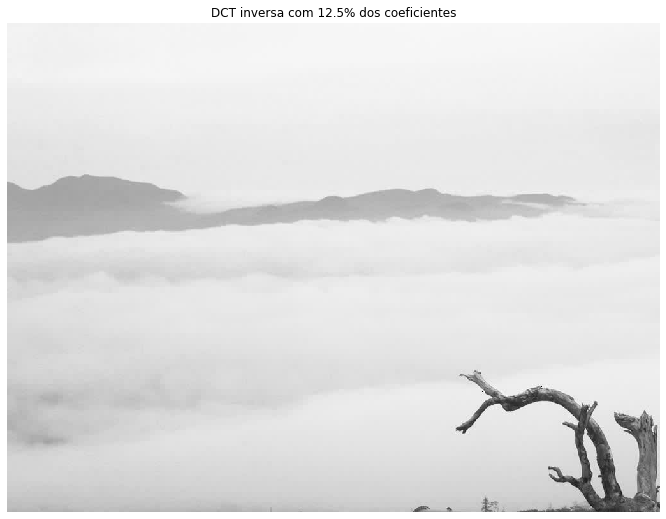

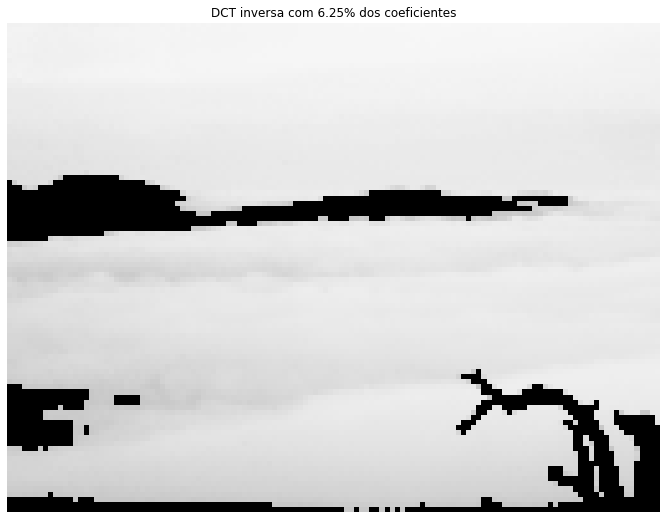

In [257]:
# Truncamento dos coeficientes para Clouds.jpg
coef = [50,25,12.5,6.25]
CLOUDS_EST = np.zeros([h,w,4])
for c in range(len(coef)):
    cloudsycc = cv2.cvtColor(clouds,cv2.COLOR_RGB2YCrCb)
    cloudsy = cloudsycc[:,:,0]
    dct_clouds = DCT_blocks(cloudsy)
    clouds_trunc = Truncated_coef(dct_clouds[:,:,0],coef[c])
    est_cloudsy = IDCT_blocks(clouds_trunc,Block_size[0])
    cloudsycc[:,:,0] = est_cloudsy
    clouds_est = cv2.cvtColor(cloudsycc,cv2.COLOR_YCrCb2RGB)
    CLOUDS_EST[:,:,c] = est_cloudsy
    plt.figure(figsize = (16,9))
    plt.imshow(clouds_est)
    plt.title('DCT inversa com '+ str(coef[c]) + '% dos coeficientes')
    plt.axis('off')
    plt.show()

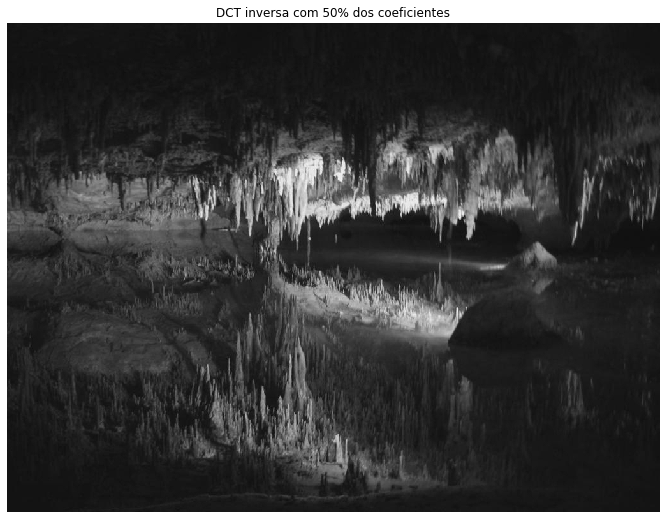

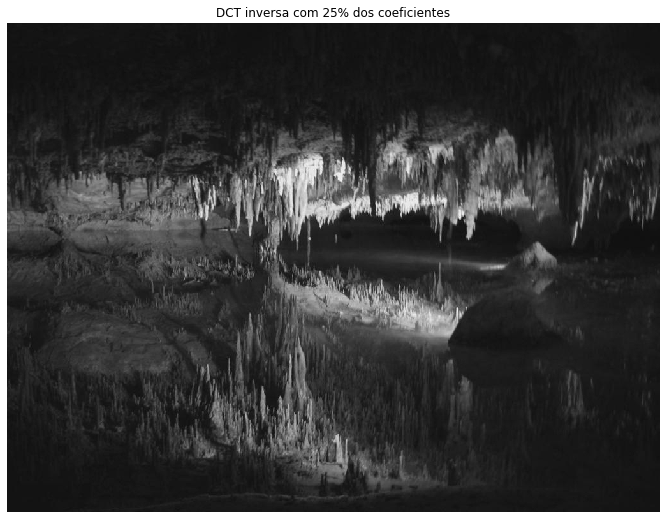

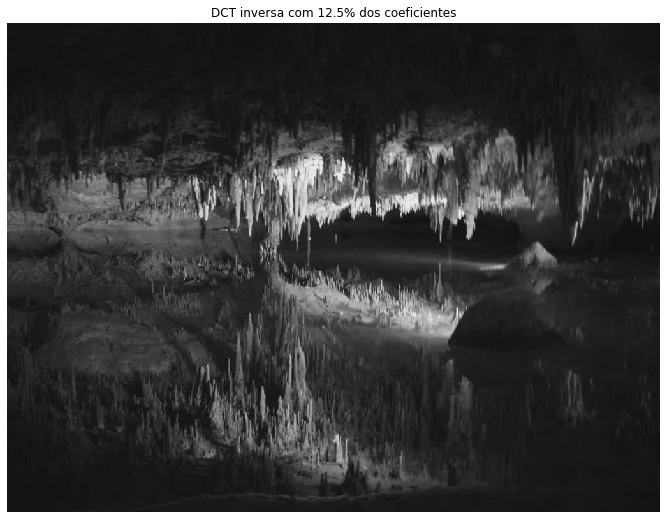

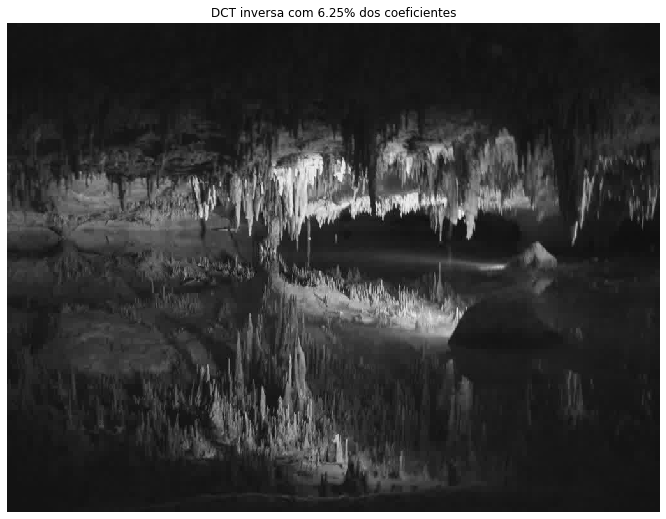

In [258]:
# Truncamento dos coeficientes
coef = [50,25,12.5,6.25]
CAVES_EST = np.zeros([h,w,4])
for c in range(len(coef)):
    cavesycc = cv2.cvtColor(caves,cv2.COLOR_RGB2YCrCb)
    cavesy = cavesycc[:,:,0]
    dct_caves = DCT_blocks(cavesy)
    caves_trunc = Truncated_coef(dct_caves[:,:,0],coef[c])
    est_cavesy = IDCT_blocks(caves_trunc,Block_size[0])
    cavesycc[:,:,0] = est_cavesy
    caves_est = cv2.cvtColor(cavesycc,cv2.COLOR_YCrCb2RGB)
    CAVES_EST[:,:,c] = est_cavesy
    plt.figure(figsize = (16,9))
    plt.imshow(caves_est)
    plt.title('DCT inversa com '+ str(coef[c]) + '% dos coeficientes')
    plt.axis('off')
    plt.show()

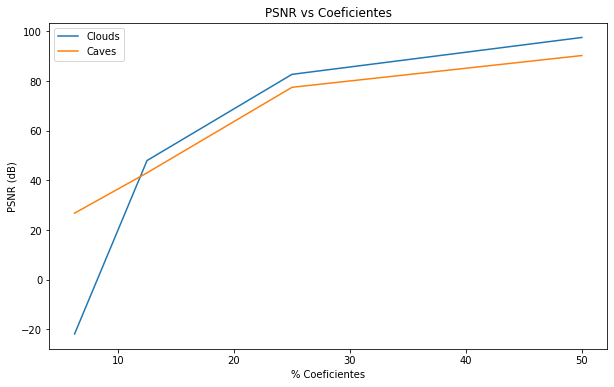

In [282]:
# Estimação da PSNR Para as figuras Clouds e Caves utilizando as imagens comprimidas anteriormente
est_PSNR = np.zeros([2,4])
for c in range(len(coef)):
    est_PSNR[0,c] = PSNR(CLOUDS_EST[:,:,c],clouds[:,:,0])
    est_PSNR[1,c] = PSNR(CAVES_EST[:,:,c],caves[:,:,0])
plt.figure(figsize = (10,6))
plt.plot(coef,est_PSNR[0,:],label = 'Clouds')
plt.plot(coef,est_PSNR[1,:],label = 'Caves')
plt.legend()
plt.title('PSNR vs Coeficientes')
plt.ylabel('PSNR (dB)')
plt.xlabel('% Coeficientes')
plt.show()

Como pode ser observado a porcentagem dos coeficientes utilizados para obter uma imagem nítida variaram. Enquanto na imagem Clouds com $6.25$ % dos coeficientes a imagem teve uma nitidez bastante deteriorada, quase lembrando imagens 8 bits.
Já a imagem caves continuou bastante nítida para todos os coeficientes. Isso ocorreu devido à distribuição dos valores dos coeficientes, como pode ser observado na imagem abaixo.

Na imagem Clouds existe uma maior concentração de coeficientes com alta energia, que carregam mais informação, enquanto na caves esses coeficientes com mais energia são menores.

Com relação a PSNR é possível observar que no caso pior da imagem clouds ele possui um valor bem baixo, indicando que a qualidade da imagem não está boa. Porém para os casos existem variações de aproximadamente 70 dB que não são perceptíveis.

C:\Users\T-Gamer\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


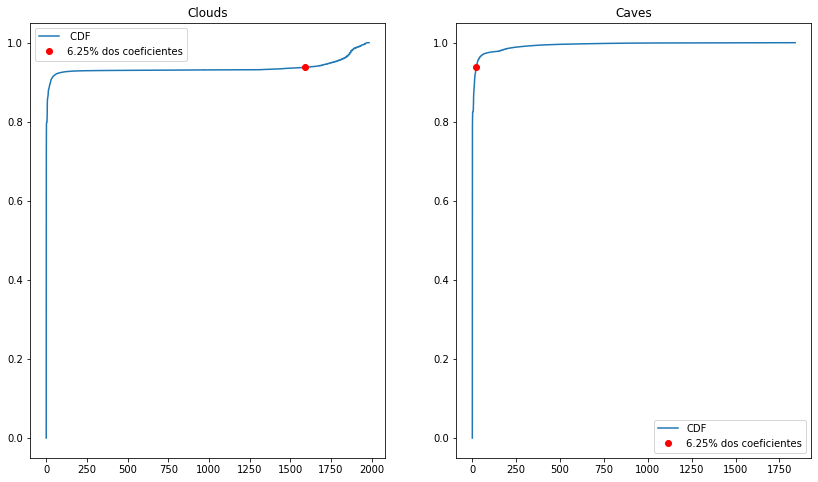

In [297]:
x,y = empirical_cdf(dct_clouds[:,:,0])
a = dct_clouds[:,:,0].reshape(h*w)
x,y = empirical_cdf(np.abs(a[np.where(a != 0)[0]]))
th = np.where(y>=(1-6.25/100))[0][0]
fig,ax = plt.subplots(1,2,figsize = (14,8))
ax[0].plot(x,y,label = ' CDF')
ax[0].set_title('Clouds')
ax[0].plot(x[th],y[th],'ro',label = '6.25% dos coeficientes')
ax[0].legend()
a = dct_caves[:,:,0].reshape(h*w)
x,y = empirical_cdf(np.abs(a[np.where(a != 0)[0]]))
th = np.where(y>=(1-6.25/100))[0][0]
ax[1].plot(x,y,label = 'CDF')
ax[1].plot(x[th],y[th],'ro',label = '6.25% dos coeficientes')
ax[1].set_title('Caves')
ax[1].legend()
plt.show()
